In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data from Excel
filepath = "../Data/Mode2/Output/mode_2_release_1_all_output.xlsx"
raw_data = pd.read_excel(filepath)

In [35]:
def process_raw_data(raw_data):
    processed_rows = []
    
    for _, row in raw_data.iterrows():
        group = row["group"]
        if pd.isna(group): continue
        task_data = json.loads(row["data"])["Data"]["taskData"][0]  # Parse the JSON data
        
        # print(task_data)
                
        grouped_data = {}
        for key, value in task_data.items():
            prefix, topic = key.rsplit('_', 1)
            if prefix not in grouped_data:
                grouped_data[prefix] = {}
            grouped_data[prefix][topic] = value
                        
        # Convert grouped data into records for DataFrame
        for prefix, topics in grouped_data.items():
            record = {"group": group, "prefix": prefix, **topics}
            processed_rows.append(record)
    
        # print(pd.DataFrame(processed_rows))
    return pd.DataFrame(processed_rows)

def extract_true_values(df_converted_converted):
    def find_true_value(mapping):
        # Identify the key with a True value
        for key, value in mapping.items():
            if value:
                return key
        return None

    # Apply to all topic columns
    topic_columns = df_converted.columns.difference(["group", "prefix"])
    for column in topic_columns:
        df[column] = df[column].apply(find_true_value)

    return df

def count_unique_values(df):
    unique_counts = {}
    for column in df.columns.difference(["group", "prefix"]):
        unique_counts[column] = df[column].value_counts().to_dict()
    return unique_counts

In [160]:
# Process and transform data
processed_data = process_raw_data(raw_data)

# Extract only the "True" values
data_with_true_values = extract_true_values(processed_data)

# Count unique values
unique_counts = count_unique_values(data_with_true_values)

# Display the results
print(data_with_true_values)
print("\nUnique counts:", unique_counts)


      group  prefix      error          reasoning         relevance validness  \
0    full_1  3000_1       None               None              None        No   
1    full_1  3000_2       None               None              None        No   
2    full_1  3000_3       None               None              None        No   
3    full_1  3000_4       None               None              None        No   
4    full_1  3001_1       None               None              None        No   
..      ...     ...        ...                ...               ...       ...   
371  org_10  3099_3       None               None              None        No   
372  org_10  3099_4  No Errors  Complex Reasoning           Related       Yes   
373  org_10  3099_5  No Errors  Complex Reasoning           Related       Yes   
374  org_10  3099_6  No Errors  Complex Reasoning           Related       Yes   
375  org_10  3099_7  No Errors  Complex Reasoning  Strongly Related       Yes   

           newInformation  

In [161]:
# release set with problem
# full_1
data_with_true_values.loc[data_with_true_values["group"] == "full_1"]

,group,prefix,error,reasoning,relevance,validness,newInformation
0,full_1,3000_1,None,None,None,No,None
1,full_1,3000_2,None,None,None,No,None
2,full_1,3000_3,None,None,None,No,None
3,full_1,3000_4,None,None,None,No,None
4,full_1,3001_1,None,None,None,No,None
5,full_1,3001_2,No Errors,Moderate Reasoning,Related,Yes,A lot of Information
6,full_1,3001_3,None,None,None,No,None
7,full_1,3002_1,None,None,None,No,None
8,full_1,3002_2,No Errors,Complex Reasoning,Related,Yes,Some Information
9,full_1,3002_3,None,None,None,No,None


In [162]:
data_with_true_values.loc[data_with_true_values["group"] == "full_5"]
data_without_full_1 = data_with_true_values[~(data_with_true_values["group"] == "full_1")]

data_without_full_1

,group,prefix,error,reasoning,relevance,validness,newInformation
43,full_5,3040_1,No Errors,Complex Reasoning,Strongly Related,Yes,A lot of Information
44,full_5,3040_2,Other Errors,Moderate Reasoning,Related,Yes,A lot of Information
45,full_5,3040_3,No Errors,Moderate Reasoning,Strongly Related,Yes,Some Information
46,full_5,3041_1,No Errors,Minimal Reasoning,Related,Yes,Some Information
47,full_5,3041_2,No Errors,Moderate Reasoning,Strongly Related,Yes,Some Information
...,...,...,...,...,...,...,...
371,org_10,3099_3,None,None,None,No,None
372,org_10,3099_4,No Errors,Complex Reasoning,Related,Yes,Some Information
373,org_10,3099_5,No Errors,Complex Reasoning,Related,Yes,A lot of Information
374,org_10,3099_6,No Errors,Complex Reasoning,Related,Yes,A lot of Information


In [163]:
df_imputed = data_without_full_1.fillna(0)
print(df_imputed)

      group  prefix         error           reasoning         relevance  \
43   full_5  3040_1     No Errors   Complex Reasoning  Strongly Related   
44   full_5  3040_2  Other Errors  Moderate Reasoning           Related   
45   full_5  3040_3     No Errors  Moderate Reasoning  Strongly Related   
46   full_5  3041_1     No Errors   Minimal Reasoning           Related   
47   full_5  3041_2     No Errors  Moderate Reasoning  Strongly Related   
..      ...     ...           ...                 ...               ...   
371  org_10  3099_3             0                   0                 0   
372  org_10  3099_4     No Errors   Complex Reasoning           Related   
373  org_10  3099_5     No Errors   Complex Reasoning           Related   
374  org_10  3099_6     No Errors   Complex Reasoning           Related   
375  org_10  3099_7     No Errors   Complex Reasoning  Strongly Related   

    validness        newInformation  
43        Yes  A lot of Information  
44        Yes  A lot of

In [164]:
# Now remove all non-valid rows
data_valid_only = data_without_full_1.loc[data_without_full_1["validness"] == "Yes"]

data_valid_only

,group,prefix,error,reasoning,relevance,validness,newInformation
43,full_5,3040_1,No Errors,Complex Reasoning,Strongly Related,Yes,A lot of Information
44,full_5,3040_2,Other Errors,Moderate Reasoning,Related,Yes,A lot of Information
45,full_5,3040_3,No Errors,Moderate Reasoning,Strongly Related,Yes,Some Information
46,full_5,3041_1,No Errors,Minimal Reasoning,Related,Yes,Some Information
47,full_5,3041_2,No Errors,Moderate Reasoning,Strongly Related,Yes,Some Information
...,...,...,...,...,...,...,...
369,org_10,3099_1,No Errors,Complex Reasoning,Strongly Related,Yes,A lot of Information
372,org_10,3099_4,No Errors,Complex Reasoning,Related,Yes,Some Information
373,org_10,3099_5,No Errors,Complex Reasoning,Related,Yes,A lot of Information
374,org_10,3099_6,No Errors,Complex Reasoning,Related,Yes,A lot of Information


In [206]:
# map values
df_converted = df_imputed.copy()

# Define mappings
# if there are no errors, assign 0. Otherwise, assign 1
validness_map = {
    "Yes": 1,
    "No": 0
}
error_map = {
    "No Errors": 0,
    "Redundant": 1,
    "Repetitive": 1,
    "Wrong Semantic Collocation": 1,
    "Other Errors": 1
}
reasoning_map = {
    "Complex Reasoning": 3,
    "Moderate Reasoning": 2,
    "Minimal Reasoning": 1,
    "No Reasoning": 0
}
relevance_map = {
    "Strongly Related": 3,
    "Related": 2,
    "Slightly Related": 1,
    "Not Related": 0
}
new_information_map = {
    "A lot of Information": 3,
    "Some Information": 2,
    "Little Information": 1,
    "No Information": 0
}

# df["key"].map(lambda x: mapping.get(x, 0))

# Apply mappings
df_converted["validness"] = df_converted["validness"].map(lambda x: validness_map.get(x, 0))
df_converted["error"] = df_converted["error"].map(lambda x: error_map.get(x, 0))
df_converted["reasoning"] = df_converted["reasoning"].map(lambda x: reasoning_map.get(x, 0))
df_converted["relevance"] = df_converted["relevance"].map(lambda x : relevance_map.get(x, 0))
df_converted["newInformation"] = df_converted["newInformation"].map(lambda x: new_information_map.get(x, 0))

df_converted["validness"] = df_converted["validness"].astype(int)
df_converted["error"] = df_converted["error"].astype(int)
df_converted["reasoning"] = df_converted["reasoning"].astype(int)
df_converted["relevance"] = df_converted["relevance"].astype(int)
df_converted["newInformation"] = df_converted["newInformation"].astype(int)
# Output the processed DataFrame
print(df_converted)

      group  prefix  error  reasoning  relevance  validness  newInformation
43   full_5  3040_1      0          3          3          1               3
44   full_5  3040_2      1          2          2          1               3
45   full_5  3040_3      0          2          3          1               2
46   full_5  3041_1      0          1          2          1               2
47   full_5  3041_2      0          2          3          1               2
..      ...     ...    ...        ...        ...        ...             ...
371  org_10  3099_3      0          0          0          0               0
372  org_10  3099_4      0          3          2          1               2
373  org_10  3099_5      0          3          2          1               3
374  org_10  3099_6      0          3          2          1               3
375  org_10  3099_7      0          3          3          1               3

[333 rows x 7 columns]


In [207]:
df_full = df_converted[df_converted["group"].str.startswith("full_")]
df_org = df_converted[df_converted["group"].str.startswith("org_")]
df_gpt = df_converted[df_converted["group"].str.startswith("gpt_")]

In [208]:
def calculateMeanVar(df):
    mean_values = df[["validness", "error", "reasoning", "relevance", "newInformation"]].mean()
    var_values = df[["validness", "error", "reasoning", "relevance", "newInformation"]].var()

    result = pd.DataFrame(
        [mean_values, var_values],
        index=["mean", "variance"]
    )

    return result

In [209]:
print(f"Mode 2 Full Data Mean and Variance Result: \n{calculateMeanVar(df_full)}")
print(f"Mode 2 Original Data Mean and Variance Result: \n{calculateMeanVar(df_org)}")
print(f"Mode 2 GPT Data Mean and Variance Result: \n{calculateMeanVar(df_gpt)}")

Mode 2 Full Data Mean and Variance Result: 
          validness     error  reasoning  relevance  newInformation
mean       0.696203  0.063291   1.113924   1.544304        1.151899
variance   0.214216  0.060045   0.794547   1.353781        0.874067
Mode 2 Original Data Mean and Variance Result: 
          validness     error  reasoning  relevance  newInformation
mean       0.734694  0.176871   1.006803   1.727891        0.877551
variance   0.196254  0.146585   1.102693   1.500792        1.149287
Mode 2 GPT Data Mean and Variance Result: 
          validness     error  reasoning  relevance  newInformation
mean       0.953271  0.177570   1.252336   2.112150        1.242991
variance   0.044966  0.147417   0.718744   1.119379        1.072474


In [210]:
# Randomly Select Test Samples to do manula evaluation
df_test_samples = df_converted.groupby('group').sample(n=3, random_state=42)

df_test_samples.to_excel("mode_2_release_1_test_sample_manual_evaluation.xlsx", index=False)

print(df_test_samples.to_markdown(index=False))

| group   |   prefix |   error |   reasoning |   relevance |   validness |   newInformation |
|:--------|---------:|--------:|------------:|------------:|------------:|-----------------:|
| full_10 |   3098_5 |       1 |           1 |           2 |           1 |                1 |
| full_10 |   3099_3 |       0 |           0 |           0 |           0 |                0 |
| full_10 |   3091_1 |       1 |           3 |           2 |           1 |                3 |
| full_5  |   3040_1 |       0 |           3 |           3 |           1 |                3 |
| full_5  |   3046_1 |       0 |           1 |           2 |           1 |                1 |
| full_5  |   3047_2 |       0 |           0 |           0 |           0 |                0 |
| gpt_1   |   3000_2 |       0 |           1 |           3 |           1 |                2 |
| gpt_1   |   3000_4 |       0 |           1 |           1 |           1 |                2 |
| gpt_1   |   3001_1 |       0 |           1 |           3 |

In [204]:
# FULL
full_test_sample_questions = {
    "full": {
        {
          "id": 3097,
          "question": "ELI5 Will bacteria eventually become immune to sanitizers?",
          "answer": "Yes, in the lab we see that different bacteria have different sensitivity to sanitizers. It also varies in what you use: chloorhexidine vs alcohol vs iodine",
          "follow-up": "Do you notice any significant degree of resistance with alcohols? Namely ethanol and isopropyl alcohol (with water). I thought they attacked cell membranes and caused leakage of the cytoplasm - could bacteria and such form a resistance to this, like how dead skin cells protects us from harmful and corrosive agents?  Also, what have been your observations with oxidising agents like peroxides, if you\u2019ve explored them?",
          "relation": "Related",
          "generated_follow_up": [
            "How do genetic mutations in bacteria affect their ability to resist sanitizers?"
          ]
        },
        {
          "id": 3093,
          "question": "ELI5: What is it in the cells of certain lizards and amphibians that allows them the ability to grow back limbs?",
          "answer": "DNA. Humans have genes that allow them to repair cuts to skin, muscle, and various other kinds of tissue. Lizards just have genes that code for growing a tail back if it gets cut off in the same way you have genes for growing new skin when you cut your skin.",
          "follow-up": "Scientifically speaking do you think it would one day be possible for humans to get to that point or would it be impossible?",
          "relation": "Slightly Related",
          "generated_follow_up": [
            "What are the specific growth factors that enable amphibians to grow back limbs?"
          ]
        },
        {
          "id": 3090,
          "question": "ELI5: What makes a photo taken of a computer screen appear to have vague lines all over it? And what makes them move, or disappear, when zoomed in/out on another device?",
          "answer": "In almost any screen the pixels are constantly refreshing. This happens so fast it's invisible to the naked eye. But when you see it on many cameras you can catch the refresh in action.",
          "follow-up": "If it is invisible to the naked eye, then what am I seeing? I am not trying to be condescending I truly do not understand what makes this happen. To further my confusion if I go to view my photos on my phone NONE of the lines are there, but when I start to move around they show up.",
          "relation": "Related",
          "generated_follow_up": [
            "What is the significance of the refresh rate of a screen in creating visual distortions?"
          ]
        },
        {
          "id": 3040,
          "question": "eli5: what is API?",
          "answer": "Pretend you own a website that tells the weather. You want me to display it on my website. You can create a way for a user to grab todays temperature. Its real simple and like one line of code for me called grab_todays_temp(). On the inside of this function its way more complex. But I can\u2019t see how it works on the inside and I don\u2019t need to know. All I care about is gettin the temperature from your website.",
          "follow-up": "in this scenario, do you also have to have an API on your end to receive today's temp? or are you given the API by the website and you simply run it in order to grab today's temp?",
          "relation": "Related",
          "generated_follow_up": [
            "What are some common use cases for API functionality in web development?"
          ]
        },
        {
          "id": 3041,
          "question": "ELI5 - how is DC current converted to AC current, for instance power from solar panels being converted to AC? I know how it can be done mechanically but that must be inefficient.",
          "answer": "Usually it will be done by switching powere on and off really fast. That will then go through a circuit that smooths the on off into a actual wave shape.  Same as if your moving your hand up and down in a bath tub. Vertical movement of your hand is smoothed out by the resistance of the water to create a horizontal wave.  The circuits use inductors and capacitors to create filters that resist the change of voltage causing the wave shape.  Edit: I guess terms would be either stable multi vibrators or oscillator. Usually",
          "follow-up": "Thanks. Surely turning it on and off 50 times a second (in the UK) would be brutal on the components? And how is the wave smoothed? As far as I understand, it must be smoothed to reduce the punishment on the components.",
          "relation": "Related",
          "generated_follow_up": [
            "Why is it important to minimize energy losses in converting DC to AC?"
          ]
        },
        {
          "id": 3046,
          "question": "ELI5:How does wierless charging work ?",
          "answer": "The power sends an alternating electromagnetic signal.  Air has a pretty high resistance to this sort of signal, and so it doesn't go very far or carry much current.  When you put the right loop in the region energized with this signal, it couples with the transmitter to reduce this resistance.  The result allows a lot more current to flow and it's that current that recharges the battery.",
          "follow-up": "How does that compare to a Tesla arc ? Like a invisible one or totaly different things ? (THX a lot for the explanation !)",
          "relation": "Related",
          "generated_follow_up": [
            "In what way does wierless charging contribute to environmental sustainability?"
          ]
        },
        
    }
}

TypeError: unhashable type: 'dict'

In [ ]:
# GPT
gpt_test_sample_questions = {
    "gpt": {
        {
            "id": 3001,
            "question": "ELI5 What is GERD?",
            "answer": "Gerd (GastroEsophageal Reflux Disease) is a problem with the sphincter that leads into the stomach. If the sphincter doesn't close properly, stomach acids can be pumped back up the esophagus. The acid is an irritant, the mucus is what the delicate tissues use to defend themselves.  Reflux is a common cause of heartburn. Constant reflux can cause cancer of the sphincter.",
            "follow-up": "I c this was the answer I was looking for. I might have sleep apnea because of this. May I ask how are we breathing if the mucus blocks the airway at night?",
            "relation": "Related",
            "generated_follow_up": [
                "What are the symptoms of GERD?",
            ]
        },
        {
            "id": 3007,
            "question": "ELI5: Is specific colors are what the object is not reflecting, how are we able to see the white light from a torch mid air?",
            "answer": "Sufficiently hot objects produce their own light, a process called \u201cblackbody radiation\u201d  Torches, incandescent bulbs, the sun - they\u2019re not reflecting light from another source, but rather generating light when very hot molecules dump energy to cool off.",
            "follow-up": "I may sound stupid here, but doesn't there needs to be something to not reflect the white color to make the light color white?",
            "relation": "Related",
            "generated_follow_up": [
                "What are some examples of high-energy emitting materials?"
            ]
        },
        {
            "id": 3006,
            "question": "ELI5: How does the McGurk Effect happen?",
            "answer": "The Ben 10 toy that produces that sample (which correctly says \u201cBrainstorm\u201das that is the name of the toy character) has a fairly low sample rate and a hanging frequency in the background.   Br and Gr sound similar enough to be confused if you have one in mind. Try listening for \u201cGrainstorm\u201d and you\u2019ll hear it.   The spurious e\u2019s in \u201cGreen Needle\u201d are the result of focusing on the background frequency instead of the intended words.",
            "follow-up": "(I'm not english, I'm sorry for any mistake I make)   So it's basically our brain choosing to interpret a frequency and the words when associated with the words on the screen? But, if I'm not looking at the screen to read or I'm thinking about something unrelated to the audio, I can still only hear Green Needle, unless I'm specifically thinking of Brainstorm. Is my brain still choosing to interpret the frequency instead of the words?",
            "relation": "Related",
            "generated_follow_up": [
                "What are the effects of focusing on the background frequency instead of the intended words in the McGurk Effect?"
            ]
        },
        {
            "id": 3097,
            "question": "ELI5 Will bacteria eventually become immune to sanitizers?",
            "answer": "Yes, in the lab we see that different bacteria have different sensitivity to sanitizers. It also varies in what you use: chloorhexidine vs alcohol vs iodine",
            "follow-up": "Do you notice any significant degree of resistance with alcohols? Namely ethanol and isopropyl alcohol (with water). I thought they attacked cell membranes and caused leakage of the cytoplasm - could bacteria and such form a resistance to this, like how dead skin cells protects us from harmful and corrosive agents?  Also, what have been your observations with oxidising agents like peroxides, if you\u2019ve explored them?",
            "relation": "Related",
            "generated_follow_up": [
                "Why is it important to balance the effectiveness of different types of sanitizers in different environments?"
            ]
        },
        {
            "id": 3099,
            "question": "ELI5: What is \"paying with money you don't have?\"",
            "answer": "Your credit will be negatively impacted and thus creditors will be less likely to loan you money or give you credit. This affects buying houses, cars, insurance rates, and even getting certain jobs.  If you owe enough money they can garnish any future wages or take out a lien on your properly. If they garnish wages, a percentage of your wages comes straight from your employer to the bank.  You can get relief through bankruptcy but certain things are not forgiven such as student loans.",
            "follow-up": "Does the person just has to find people willing to house them and feed them, when all their wages are seized? Does it mean you just become homeless?  As for the lender, essentially their money was transferred to the service that was paid. If the service was some goods at least that can be seized, but otherwise it's just service they didn't get. Do lenders just succesfully make enough money with non-offending loaners to cover for these losses and still profit, or is there something else at play that justifies that lending would exist as it does?",
            "relation": "Related",
            "generated_follow_up": [
                "Can you explain the process of credit history and how it relates to money management?"
            ]
        },
        {
            "id": 3091,
            "question": "ELI5: If Carbon Capture is Possible but impractical due to the storage once it is accomplished, what prevents us from storing sequestration products it in previously tapped oil reservoirs?",
            "answer": "Consider - if you could efficiently capture carbon out of the air into a usable fuel source, why would engines spew it out as waste through the tailpipe instead of capturing and pumping it back into the gas tank? The answer is that the energy required to do this is greater than the energy you get out of it, so you'd burn more gas than you get. Which could be fine if you are using a green energy to perform this process, but at that point it's not particularly productive since you're using more energy than you're capturing. Especially since at that point, synthetic fuels are more efficient.",
            "follow-up": "So basically a future reality with tons of carbon capture and still burning fossil fuels is a ridiculous oil industry myth/fraud because there is no possible way we\u2019d use the huge amount of green energy sources required to offset continuing to burn fossil fuels instead of just replacing fossil fuels?  So maybe only carbon capture would work for atmospheric removal/climate engineering?",
            "relation": "Related",
            "generated_follow_up": [
                "What are the economic risks associated with storing carbon in previously tapped oil reservoirs?"
            ]
        },
        {
            "id": 3041,
            "question": "ELI5 - how is DC current converted to AC current, for instance power from solar panels being converted to AC? I know how it can be done mechanically but that must be inefficient.",
            "answer": "Usually it will be done by switching powere on and off really fast. That will then go through a circuit that smooths the on off into a actual wave shape.  Same as if your moving your hand up and down in a bath tub. Vertical movement of your hand is smoothed out by the resistance of the water to create a horizontal wave.  The circuits use inductors and capacitors to create filters that resist the change of voltage causing the wave shape.  Edit: I guess terms would be either stable multi vibrators or oscillator. Usually",
            "follow-up": "Thanks. Surely turning it on and off 50 times a second (in the UK) would be brutal on the components? And how is the wave smoothed? As far as I understand, it must be smoothed to reduce the punishment on the components.",
            "relation": "Related",
            "generated_follow_up": [
                "How do DC current converters convert to AC using a DC to AC converters?"
            ]
        },
        {
            "id": 3040,
            "question": "eli5: what is API?",
            "answer": "Pretend you own a website that tells the weather. You want me to display it on my website. You can create a way for a user to grab todays temperature. Its real simple and like one line of code for me called grab_todays_temp(). On the inside of this function its way more complex. But I can\u2019t see how it works on the inside and I don\u2019t need to know. All I care about is gettin the temperature from your website.",
            "follow-up": "in this scenario, do you also have to have an API on your end to receive today's temp? or are you given the API by the website and you simply run it in order to grab today's temp?",
            "relation": "Related",
            "generated_follow_up": [
                "Can you explain how RESTful APIs enhance user engagement and collaboration in API development?"
            ]
        },
        {
            "id": 3044,
            "question": "ELi5 - How do clothes get dry when hung outdoors in winter?",
            "answer": "Water evaporates when individual molecules gain enough energy to break free of the rest of the liquid.  Individual molecules don't have a temperature, they just have energy.  Temperature of something is basically just the average energy of it. So while the temperature of a pool of water may be well below boiling individual molecules are going to be hit by photons or whatever and gain enough energy to leave the water.",
            "follow-up": "Interesting. Would these water molecules not use convection to normalize their excess energy before they evaporate?",
            "relation": "Strongly Related",
            "generated_follow_up": [
                "How does the interaction between air molecules and moisture molecules contribute to the drying process?"
            ]
        },
    }
}

In [ ]:
# ORGINAL
org_test_sample_questions = {
    "org": {
        {
            "id": 3004,
            "question": "eli5 how is the basic of minecraft. game....like what we are doing in that game...i saw a youtube stream...dont understand?",
            "answer": "The endgame is to get to \"the end\" where there is a dragon you need to kill. To do so, you need to craft various things.  But it's also pretty much a sandbox game; you can do whatever you like.",
            "follow-up": "Wasn't the End dimension only added to minecraft so that Microsoft would be more willing to buy it?",
            "relation": "Slightly Related",
            "generated_follow_up": [
                "What is the endgame?"
            ]
        },
        {
            "id": 3004,
            "question": "eli5 how is the basic of minecraft. game....like what we are doing in that game...i saw a youtube stream...dont understand?",
            "answer": "The endgame is to get to \"the end\" where there is a dragon you need to kill. To do so, you need to craft various things.  But it's also pretty much a sandbox game; you can do whatever you like.",
            "follow-up": "Wasn't the End dimension only added to minecraft so that Microsoft would be more willing to buy it?",
            "relation": "Slightly Related",
            "generated_follow_up": [
                "So basically, you need to kill dragons to get to the end?"
            ]
        },
        {
            "id": 3005,
            "question": "ELI5: How do you take a picture/screenshot of a bluescreen?",
            "answer": "You can write down the message or take a photo of the screen.   If it occurs within a virtual machine, then you can screenshot within the host OS.",
            "follow-up": "Thank you for your explanation. I have a few follow up questions though:  What exactly is a virtual machine? If an emulator crashes but Windows still works? Would the emulator be the virtual machine?  And if you take a photo, you just recreate it in Photoshop? What about bluescreen on older computers? Were they only created later?",
            "relation": "Related",
            "generated_follow_up": [
                "I see, but how do you take screenshots of a bluescreen?",
            ]
        },
        {
            "id": 3093,
            "question": "ELI5: What is it in the cells of certain lizards and amphibians that allows them the ability to grow back limbs?",
            "answer": "DNA. Humans have genes that allow them to repair cuts to skin, muscle, and various other kinds of tissue. Lizards just have genes that code for growing a tail back if it gets cut off in the same way you have genes for growing new skin when you cut your skin.",
            "follow-up": "Scientifically speaking do you think it would one day be possible for humans to get to that point or would it be impossible?",
            "relation": "Slightly Related",
            "generated_follow_up": [
                "What about lizards that have been found to have been born without tail fins?",
            ]
        },
        {
            "id": 3092,
            "question": "ELI5: What is a heat dome?",
            "answer": "Is when the high pressure in the atmosphere traps the hot air in below. As you would know, the hot air rises, which only causes the air to compress because of the pressure from above and it gets hotter, hotter, hotter and denser (That's why you would kill for a glass of water, the hot air is literally pushing you against more hot air)",
            "follow-up": "Thank you. What causes the air in the atmosphere to have higher pressure than the heavy air closer to the surface?",
            "relation": "Related",
            "generated_follow_up": [
                "Thanks for the answer!  So is it just a matter of air pressure or is there a deeper layer of air that is absorbing the heat?",
            ]
        },
        {
            "id": 3094,
            "question": "ELI5: Why do some spicy foods hit hard and fade quickly (wasabi), while others start subtle but build up (flaming hot Cheetos), and others hit hard, stay a long time, and ruin my sleep (lamb vindaloo)?",
            "answer": "It's all dependent on the rate at which the chemicals that cause the spiciness break down.  Capsaicin is oil-based, so it takes a while to break down, and the more capsaicin you eat the longer it takes your body to deal with.  Allyl isothiocynate (which causes the pungency in wasabi, horseradish, and mustard) is *not* an oil, and tends to break apart much faster, hence why you end up with a quick hit of flavor that doesn't last very long, and which can actually be washed away relatively easily.",
            "follow-up": ">Allyl isothiocynate (which causes the pungency in wasabi, horseradish, and mustard) is    >   >not   >   > an oil  &#x200B;  So is wikipedia wrong on this one?  &#x200B;   [https://en.wikipedia.org/wiki/Allyl\\_isothiocyanate](https://en.wikipedia.org/wiki/Allyl_isothiocyanate)   > **Allyl isothiocyanate** (**AITC**) is the [organosulfur compound](https://en.wikipedia.org/wiki/Organosulfur_compound) with the formula CH2CHCH2NCS. This colorless oil is responsible for the pungent taste of [mustard](https://en.wikipedia.org/wiki/Mustard_(condiment)), [radish](https://en.wikipedia.org/wiki/Radish), [horseradish](https://en.wikipedia.org/wiki/Horseradish), and [wasabi](https://en.wikipedia.org/wiki/Wasabi).",
            "relation": "Related",
            "generated_follow_up": [
                ">It's all dependent on the rate at which the chemicals that cause the spiciness break down.  Is it possible to reduce the amount of capsaicin in your body?"
            ]
        },
        {
            "id": 3044,
            "question": "ELi5 - How do clothes get dry when hung outdoors in winter?",
            "answer": "Water evaporates when individual molecules gain enough energy to break free of the rest of the liquid.  Individual molecules don't have a temperature, they just have energy.  Temperature of something is basically just the average energy of it. So while the temperature of a pool of water may be well below boiling individual molecules are going to be hit by photons or whatever and gain enough energy to leave the water.",
            "follow-up": "Interesting. Would these water molecules not use convection to normalize their excess energy before they evaporate?",
            "relation": "Strongly Related",
            "generated_follow_up": [
                "So if I put a sheet of plastic over a hot water heater and turn it off, the clothes will get dry?"
            ]
        },
        {
            "id": 3044,
            "question": "ELi5 - How do clothes get dry when hung outdoors in winter?",
            "answer": "Water evaporates when individual molecules gain enough energy to break free of the rest of the liquid.  Individual molecules don't have a temperature, they just have energy.  Temperature of something is basically just the average energy of it. So while the temperature of a pool of water may be well below boiling individual molecules are going to be hit by photons or whatever and gain enough energy to leave the water.",
            "follow-up": "Interesting. Would these water molecules not use convection to normalize their excess energy before they evaporate?",
            "relation": "Strongly Related",
            "generated_follow_up": [
                "So water is just a liquid that absorbs photons?",
            ]
        },
        {
            "id": 3044,
            "question": "ELi5 - How do clothes get dry when hung outdoors in winter?",
            "answer": "Water evaporates when individual molecules gain enough energy to break free of the rest of the liquid.  Individual molecules don't have a temperature, they just have energy.  Temperature of something is basically just the average energy of it. So while the temperature of a pool of water may be well below boiling individual molecules are going to be hit by photons or whatever and gain enough energy to leave the water.",
            "follow-up": "Interesting. Would these water molecules not use convection to normalize their excess energy before they evaporate?",
            "relation": "Strongly Related",
            "generated_follow_up": [
                "What happens if the water is too hot?"
            ]
        },
    }
}

In [211]:
# Worker's Manual test sample evaluation
worker_release_1_eval = pd.read_excel('/Users/tkang/Documents/research/nlp_followupqg/Human_Evaluation/Data/Mode2/Analysis/mode_2_release_1_manual_test_evaluation.xlsx', sheet_name="worker_release_1")

print(worker_release_1_eval.to_markdown(index=False))


| group   |   prefix |   error |   reasoning |   relevance |   validness |   newInformation |
|:--------|---------:|--------:|------------:|------------:|------------:|-----------------:|
| full_10 |   3097_4 |       0 |           2 |           3 |           1 |                1 |
| full_10 |   3093_2 |       0 |           1 |           3 |           1 |                1 |
| full_10 |   3090_1 |       0 |           2 |           2 |           1 |                2 |
| full_5  |   3040_1 |       0 |           3 |           3 |           1 |                3 |
| full_5  |   3041_3 |       0 |           1 |           2 |           1 |                2 |
| full_5  |   3046_3 |       0 |           2 |           1 |           1 |                2 |
| gpt_1   |   3001_1 |       0 |           1 |           3 |           1 |                2 |
| gpt_1   |   3007_4 |       0 |           1 |           2 |           1 |                2 |
| gpt_1   |   3006_1 |       0 |           2 |           3 |

In [212]:
# David's Manual test sample evaluation
david_release_1_eval = pd.read_excel('/Users/tkang/Documents/research/nlp_followupqg/Human_Evaluation/Data/Mode2/Analysis/mode_2_release_1_manual_test_evaluation.xlsx', sheet_name="david_release_1")

print(david_release_1_eval.to_markdown(index=False))


| group   |   prefix |   error |   reasoning |   relevance |   validness |   newInformation |
|:--------|---------:|--------:|------------:|------------:|------------:|-----------------:|
| full_10 |   3097_4 |       0 |           2 |           2 |           1 |                2 |
| full_10 |   3093_2 |       0 |           1 |           2 |           1 |                1 |
| full_10 |   3090_1 |       0 |           2 |           2 |           1 |                1 |
| full_5  |   3040_1 |       0 |           2 |           3 |           1 |                2 |
| full_5  |   3041_3 |       0 |           1 |           1 |           1 |                2 |
| full_5  |   3046_3 |       0 |           2 |           1 |           1 |                2 |
| gpt_1   |   3001_1 |       0 |           2 |           2 |           1 |                1 |
| gpt_1   |   3007_4 |       0 |           1 |           0 |           1 |                2 |
| gpt_1   |   3006_1 |       0 |           1 |           3 |

In [213]:
# Zhe's Manual test sample evaluation
zhe_release_1_eval = pd.read_excel('/Users/tkang/Documents/research/nlp_followupqg/Human_Evaluation/Data/Mode2/Analysis/mode_2_release_1_manual_test_evaluation.xlsx', sheet_name="zhe_release_1")

print(zhe_release_1_eval.to_markdown(index=False))


| group   |   prefix |   error |   reasoning |   relevance |   validness |   newInformation |
|:--------|---------:|--------:|------------:|------------:|------------:|-----------------:|
| full_10 |   3097_4 |       0 |           2 |           3 |           1 |                2 |
| full_10 |   3093_2 |       0 |           1 |           3 |           1 |                1 |
| full_10 |   3090_1 |       0 |           2 |           2 |           1 |                2 |
| full_5  |   3040_1 |       0 |           2 |           3 |           1 |                2 |
| full_5  |   3041_3 |       0 |           2 |           2 |           1 |                2 |
| full_5  |   3046_3 |       0 |           2 |           2 |           1 |                2 |
| gpt_1   |   3001_1 |       0 |           3 |           3 |           1 |                3 |
| gpt_1   |   3007_4 |       0 |           1 |           1 |           1 |                2 |
| gpt_1   |   3006_1 |       0 |           1 |           3 |

In [214]:
import pandas as pd

df_worker = worker_release_1_eval.copy()
df_david = david_release_1_eval.copy()
df_zhe = zhe_release_1_eval.copy()

def change_col_name(df, name):
    df.columns = [
        col + f'_{name}' if col not in ['group', 'prefix'] else col 
        for col in df.columns
    ]
    
    return df

change_col_name(df_david, 'david')
change_col_name(df_zhe, 'zhe')
change_col_name(df_worker, 'worker')

print(df_david)


      group  prefix  error_david  reasoning_david  relevance_david  \
0   full_10  3097_4            0                2                2   
1   full_10  3093_2            0                1                2   
2   full_10  3090_1            0                2                2   
3    full_5  3040_1            0                2                3   
4    full_5  3041_3            0                1                1   
5    full_5  3046_3            0                2                1   
6     gpt_1  3001_1            0                2                2   
7     gpt_1  3007_4            0                1                0   
8     gpt_1  3006_1            0                1                3   
9    gpt_10  3097_2            0                2                3   
10   gpt_10  3099_4            0                2                2   
11   gpt_10  3091_2            0                3                3   
12    gpt_5  3041_2            1                1                2   
13    gpt_5  3040_2 

In [215]:
merged_df = df_david.merge(df_zhe, on=['group', 'prefix'], how='outer').merge(df_worker, on=['group', 'prefix'], how='outer')

merged_df

,group,prefix,error_david,reasoning_david,relevance_david,validness_david,newInformation_david,error_zhe,reasoning_zhe,relevance_zhe,validness_zhe,newInformation_zhe,error_worker,reasoning_worker,relevance_worker,validness_worker,newInformation_worker
0,full_10,3090_1,0,2,2,1,1,0,2,2,1,2,0,2,2,1,2
1,full_10,3093_2,0,1,2,1,1,0,1,3,1,1,0,1,3,1,1
2,full_10,3097_4,0,2,2,1,2,0,2,3,1,2,0,2,3,1,1
3,full_5,3040_1,0,2,3,1,2,0,2,3,1,2,0,3,3,1,3
4,full_5,3041_3,0,1,1,1,2,0,2,2,1,2,0,1,2,1,2
5,full_5,3046_3,0,2,1,1,2,0,2,2,1,2,0,2,1,1,2
6,gpt_1,3001_1,0,2,2,1,1,0,3,3,1,3,0,1,3,1,2
7,gpt_1,3006_1,0,1,3,1,3,0,1,3,1,1,0,2,3,1,2
8,gpt_1,3007_4,0,1,0,1,2,0,1,1,1,2,0,1,2,1,2
9,gpt_10,3091_2,0,3,3,1,2,0,3,3,1,2,0,1,3,1,1


In [216]:
# convert values to 0 and 1 (0 if value is 0, and 1 if otherwise)
df = merged_df.copy()

columns_to_modify = [col for col in df.columns if any(col.startswith(prefix) for prefix in ["reasoning", "relevance", "newInformation"])]

# Update the selected columns
for col in columns_to_modify:
    df[col] = df[col].apply(lambda x: 0 if x == 0 else 1)

# Display the updated DataFrame
df

,group,prefix,error_david,reasoning_david,relevance_david,validness_david,newInformation_david,error_zhe,reasoning_zhe,relevance_zhe,validness_zhe,newInformation_zhe,error_worker,reasoning_worker,relevance_worker,validness_worker,newInformation_worker
0,full_10,3090_1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1
1,full_10,3093_2,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1
2,full_10,3097_4,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1
3,full_5,3040_1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1
4,full_5,3041_3,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1
5,full_5,3046_3,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1
6,gpt_1,3001_1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1
7,gpt_1,3006_1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1
8,gpt_1,3007_4,0,1,0,1,1,0,1,1,1,1,0,1,1,1,1
9,gpt_10,3091_2,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1


In [217]:
### for 0 if 0, and 1 if otherwise
# List of columns to calculate percent agreement for
columns_to_check = ['error', 'reasoning', 'relevance', 'validness', 'newInformation']

# Function to calculate percent agreement score
def calculate_percent_agreement(df, columns_to_check):
    results = {}
    
    for column in columns_to_check:
        # Construct the column names for each person
        david_column = f"{column}_david"
        zhe_column = f"{column}_zhe"
        worker_column = f"{column}_worker"
        
        # Calculate percent agreement between david, zhe, and worker
        agreement_david_zhe = (df[david_column] == df[zhe_column]).mean() * 100
        agreement_david_worker = (df[david_column] == df[worker_column]).mean() * 100
        agreement_zhe_worker = (df[zhe_column] == df[worker_column]).mean() * 100
        
        # Store results in dictionary
        results[column] = {
            'david_zhe_percent_agreement': agreement_david_zhe,
            'david_worker_percent_agreement': agreement_david_worker,
            'zhe_worker_percent_agreement': agreement_zhe_worker
        }
    
    return results

# Calculate percent agreement
percent_agreement = calculate_percent_agreement(df, columns_to_check)

# Display results
for column, agreements in percent_agreement.items():
    print(f"Percent Agreement for '{column}':")
    for key, value in agreements.items():
        print(f"  {key}: {value:.2f}%")

Percent Agreement for 'error':
  david_zhe_percent_agreement: 95.83%
  david_worker_percent_agreement: 79.17%
  zhe_worker_percent_agreement: 83.33%
Percent Agreement for 'reasoning':
  david_zhe_percent_agreement: 91.67%
  david_worker_percent_agreement: 79.17%
  zhe_worker_percent_agreement: 87.50%
Percent Agreement for 'relevance':
  david_zhe_percent_agreement: 91.67%
  david_worker_percent_agreement: 95.83%
  zhe_worker_percent_agreement: 95.83%
Percent Agreement for 'validness':
  david_zhe_percent_agreement: 95.83%
  david_worker_percent_agreement: 100.00%
  zhe_worker_percent_agreement: 95.83%
Percent Agreement for 'newInformation':
  david_zhe_percent_agreement: 91.67%
  david_worker_percent_agreement: 79.17%
  zhe_worker_percent_agreement: 87.50%


In [218]:
# convert values to 0 and 1 (0 if value is 0 or 1, and 1 if otherwise)
df = merged_df.copy()

columns_to_modify = [col for col in df.columns if any(col.startswith(prefix) for prefix in ["reasoning", "relevance", "newInformation"])]

# Update the selected columns
for col in columns_to_modify:
    df[col] = df[col].apply(lambda x: 0 if x in [0, 1] else 1)

# Display the updated DataFrame
df

,group,prefix,error_david,reasoning_david,relevance_david,validness_david,newInformation_david,error_zhe,reasoning_zhe,relevance_zhe,validness_zhe,newInformation_zhe,error_worker,reasoning_worker,relevance_worker,validness_worker,newInformation_worker
0,full_10,3090_1,0,1,1,1,0,0,1,1,1,1,0,1,1,1,1
1,full_10,3093_2,0,0,1,1,0,0,0,1,1,0,0,0,1,1,0
2,full_10,3097_4,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0
3,full_5,3040_1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1
4,full_5,3041_3,0,0,0,1,1,0,1,1,1,1,0,0,1,1,1
5,full_5,3046_3,0,1,0,1,1,0,1,1,1,1,0,1,0,1,1
6,gpt_1,3001_1,0,1,1,1,0,0,1,1,1,1,0,0,1,1,1
7,gpt_1,3006_1,0,0,1,1,1,0,0,1,1,0,0,1,1,1,1
8,gpt_1,3007_4,0,0,0,1,1,0,0,0,1,1,0,0,1,1,1
9,gpt_10,3091_2,0,1,1,1,1,0,1,1,1,1,0,0,1,1,0


In [219]:
# List of columns to calculate percent agreement for
columns_to_check = ['error', 'reasoning', 'relevance', 'validness', 'newInformation']

# Function to calculate percent agreement score
def calculate_percent_agreement(df, columns_to_check):
    results = {}
    
    for column in columns_to_check:
        # Construct the column names for each person
        david_column = f"{column}_david"
        zhe_column = f"{column}_zhe"
        worker_column = f"{column}_worker"
        
        # Calculate percent agreement between david, zhe, and worker
        agreement_david_zhe = (df[david_column] == df[zhe_column]).mean() * 100
        agreement_david_worker = (df[david_column] == df[worker_column]).mean() * 100
        agreement_zhe_worker = (df[zhe_column] == df[worker_column]).mean() * 100
        
        # Store results in dictionary
        results[column] = {
            'david_zhe_percent_agreement': agreement_david_zhe,
            'david_worker_percent_agreement': agreement_david_worker,
            'zhe_worker_percent_agreement': agreement_zhe_worker
        }
    
    return results

# Calculate percent agreement
percent_agreement = calculate_percent_agreement(df, columns_to_check)

# Display results
for column, agreements in percent_agreement.items():
    print(f"Percent Agreement for '{column}':")
    for key, value in agreements.items():
        print(f"  {key}: {value:.2f}%")

Percent Agreement for 'error':
  david_zhe_percent_agreement: 95.83%
  david_worker_percent_agreement: 79.17%
  zhe_worker_percent_agreement: 83.33%
Percent Agreement for 'reasoning':
  david_zhe_percent_agreement: 87.50%
  david_worker_percent_agreement: 75.00%
  zhe_worker_percent_agreement: 70.83%
Percent Agreement for 'relevance':
  david_zhe_percent_agreement: 79.17%
  david_worker_percent_agreement: 91.67%
  zhe_worker_percent_agreement: 79.17%
Percent Agreement for 'validness':
  david_zhe_percent_agreement: 95.83%
  david_worker_percent_agreement: 100.00%
  zhe_worker_percent_agreement: 95.83%
Percent Agreement for 'newInformation':
  david_zhe_percent_agreement: 79.17%
  david_worker_percent_agreement: 70.83%
  zhe_worker_percent_agreement: 75.00%


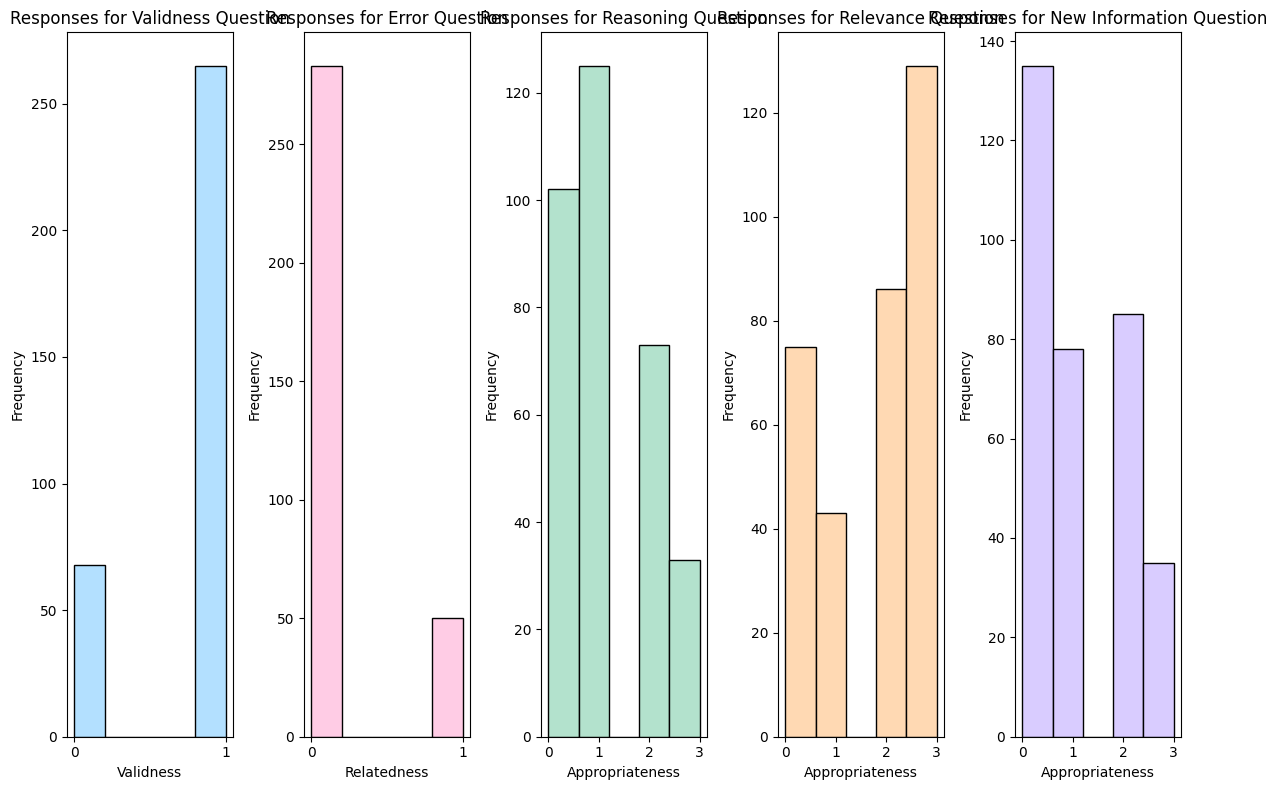

In [187]:

# Histogram of each questions
# Create separate histograms for each column
df = df_converted.copy()
plt.figure(figsize=(12, 8))
colors = ['#B3E0FF', '#FFCCE5', '#B3E2CD', '#FFD9B3', '#D9CCFF']

plt.subplot(1, 5, 1)
plt.hist(df['validness'], bins=5, edgecolor='black', color=colors[0])
plt.title('Responses for Validness Question')
plt.xlabel('Validness')
plt.ylabel('Frequency')
plt.xticks(np.arange(int(df['validness'].min()), int(df['validness'].max()) + 1, 1))

plt.subplot(1, 5, 2)
plt.hist(df['error'], bins=5, edgecolor='black', color=colors[1])
plt.title('Responses for Error Question')
plt.xlabel('Relatedness')
plt.ylabel('Frequency')
plt.xticks(np.arange(int(df['error'].min()), int(df['error'].max()) + 1, 1))

plt.subplot(1, 5, 3)
plt.hist(df['reasoning'], bins=5, edgecolor='black', color=colors[2])
plt.title('Responses for Reasoning Question')
plt.xlabel('Appropriateness')
plt.ylabel('Frequency')
plt.xticks(np.arange(int(df['reasoning'].min()), int(df['reasoning'].max()) + 1, 1))

plt.subplot(1, 5, 4)
plt.hist(df['relevance'], bins=5, edgecolor='black', color=colors[3])
plt.title('Responses for Relevance Question')
plt.xlabel('Appropriateness')
plt.ylabel('Frequency')
plt.xticks(np.arange(int(df['relevance'].min()), int(df['relevance'].max()) + 1, 1))

plt.subplot(1, 5, 5)
plt.hist(df['newInformation'], bins=5, edgecolor='black', color=colors[4])
plt.title('Responses for New Information Question')
plt.xlabel('Appropriateness')
plt.ylabel('Frequency')
plt.xticks(np.arange(int(df['newInformation'].min()), int(df['newInformation'].max()) + 1, 1))

plt.tight_layout()
plt.show()

In [86]:
### For Mode 3, just use the values in df as these only contain 'valid' follow-up questions
df

,group,prefix,error,reasoning,relevance,validness,newInformation
43,full_5,3040_1,0,3,3,1,3
44,full_5,3040_2,1,2,2,1,3
45,full_5,3040_3,0,2,3,1,2
46,full_5,3041_1,0,1,2,1,2
47,full_5,3041_2,0,2,3,1,2
...,...,...,...,...,...,...,...
369,org_10,3099_1,0,3,3,1,3
372,org_10,3099_4,0,3,2,1,2
373,org_10,3099_5,0,3,2,1,3
374,org_10,3099_6,0,3,2,1,3


In [ ]:
# Mode 3 Helper Function - to retrieve only the 'valid' follow-up questions from Mode 2 from the original dataset to be used in Mode 3

